In [24]:
#!/usr/bin/env python3
"""
Complete post-training optimization pipeline for Binary Neural Networks (BNNs)
with TALL evaluation and hardware deployment preparation.

This pipeline includes:
1. Baseline evaluation
2. BatchNorm folding
3. Bias constant clamping
4. TALL parameter optimization
5. Hardware export

Usage:
    python post_training_pipeline.py --model-path bnn_deep_best.pth --model-type deep
"""

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import argparse
import time
import numpy as np
import os
import csv
from tqdm import tqdm
from copy import deepcopy

from BNN_model import (
    BinaryMLP, TALLClassifier, 
    build_cam4_deep, build_cam4_shallow,
    apply_post_training_optimization,
    export_hardware_weights,
    create_hardware_checkpoint
)


class PostTrainingPipeline:
    """
    Complete post-training optimization pipeline for BNNs.
    
    This class handles the entire workflow from a trained model
    to hardware-ready deployment with TALL optimization.
    """
    
    def __init__(self, model, test_loader, device, verbose=True):
        self.original_model = model
        self.test_loader = test_loader
        self.device = device
        self.verbose = verbose
        
        # Pipeline stages
        self.baseline_model = None
        self.folded_model = None
        self.clamped_model = None
        self.tall_optimized_model = None
        
        # Results tracking
        self.results = {
            'baseline_accuracy': 0.0,
            'folded_accuracy': 0.0,
            'clamped_accuracy': 0.0,
            'tall_accuracy': 0.0,
            'best_tall_params': None,
            'hardware_ready': False
        }
    
    def log(self, message):
        """Print message if verbose mode is enabled"""
        if self.verbose:
            print(message)
    
    def evaluate_model(self, model, use_tall=False, tall_params=None):
        """Evaluate a model and return accuracy"""
        model.eval()
        correct = 0
        total = 0
        
        # Only wrap with TALL if requested and model is not already a TALLClassifier
        if use_tall and tall_params and not isinstance(model, TALLClassifier):
            model = TALLClassifier(
                model, 
                num_iter=tall_params['num_iter'], 
                flip_p=tall_params['flip_p']
            ).to(self.device)
            model.eval()
        
        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                
                if use_tall:
                    pred = model(data)  # TALL returns class indices directly
                else:
                    output = model(data)
                    pred = output.argmax(dim=1)
                
                correct += pred.eq(target).sum().item()
                total += target.size(0)
        
        accuracy = 100. * correct / total
        return accuracy
    
    def stage1_baseline_evaluation(self):
        """Stage 1: Evaluate baseline model performance"""
        self.log("\n" + "="*60)
        self.log("STAGE 1: BASELINE EVALUATION")
        self.log("="*60)
        
        # Keep original model unchanged
        self.baseline_model = deepcopy(self.original_model)
        accuracy = self.evaluate_model(self.baseline_model)
        
        self.results['baseline_accuracy'] = accuracy
        self.log(f"Baseline accuracy: {accuracy:.4f}%")
        
        return accuracy
    
    def stage2_batch_norm_folding(self):
        """Stage 2: Fold BatchNorm layers into linear layers"""
        self.log("\n" + "="*60)
        self.log("STAGE 2: BATCH NORM FOLDING")
        self.log("="*60)
        
        # Apply BatchNorm folding
        self.folded_model = deepcopy(self.baseline_model)
        
        # Import the folding function from BNN_model
        from BNN_model import fold_batch_norm
        
        # Apply folding to hidden layers
        self.folded_model.hidden = fold_batch_norm(self.folded_model.hidden)
        
        # Evaluate folded model
        accuracy = self.evaluate_model(self.folded_model)
        self.results['folded_accuracy'] = accuracy
        
        self.log(f"Folded model accuracy: {accuracy:.4f}%")
        self.log(f"Accuracy change: {accuracy - self.results['baseline_accuracy']:+.4f}%")
        
        return accuracy
    
    def stage3_bias_clamping(self, c_max=32, even_only=True):
        """Stage 3: Clamp bias constants for hardware compatibility"""
        self.log("\n" + "="*60)
        self.log(f"STAGE 3: BIAS CLAMPING (C_MAX={c_max}, EVEN_ONLY={even_only})")
        self.log("="*60)
        
        # Apply bias clamping
        self.clamped_model = deepcopy(self.folded_model)
        
        # Import the clamping function from BNN_model
        from BNN_model import clamp_bn_constants, BinarizeLinearWithFoldedBN
        
        # Apply clamping to all folded layers
        clamped_layers = 0
        for module in self.clamped_model.modules():
            if isinstance(module, BinarizeLinearWithFoldedBN):
                clamp_bn_constants(module, c_max, even_only)
                clamped_layers += 1
        
        self.log(f"Clamped {clamped_layers} layers with C_MAX={c_max}")
        
        # Evaluate clamped model
        accuracy = self.evaluate_model(self.clamped_model)
        self.results['clamped_accuracy'] = accuracy
        
        self.log(f"Clamped model accuracy: {accuracy:.4f}%")
        self.log(f"Accuracy change from folded: {accuracy - self.results['folded_accuracy']:+.4f}%")
        self.log(f"Accuracy change from baseline: {accuracy - self.results['baseline_accuracy']:+.4f}%")
        
        return accuracy
    
    def stage4_tall_optimization(self, parameter_sweep=True, output_dir=None, c_max=32):
        """Stage 4: Optimize TALL parameters for best performance"""
        self.log("\n" + "="*60)
        self.log("STAGE 4: TALL OPTIMIZATION")
        self.log("="*60)
        
        self.tall_optimized_model = self.clamped_model
        
        if not parameter_sweep:
            # Use default TALL parameters
            tall_params = {'num_iter': 30, 'flip_p': 0.3}
            accuracy = self.evaluate_model(self.tall_optimized_model, use_tall=True, tall_params=tall_params)
            self.results['tall_accuracy'] = accuracy
            self.results['best_tall_params'] = tall_params
            
            self.log(f"TALL accuracy (default params): {accuracy:.4f}%")
            return accuracy
        
        # Comprehensive parameter sweep
        self.log("Performing comprehensive TALL parameter sweep...")
        
        # Reduced parameter space for efficiency
        flip_probs = [0.05,0.10,0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45]
        iterations = [1, 5, 10, 20, 30, 40, 50, 100, 200]
        
        best_acc = 0
        best_params = None
        sweep_results = {}
        
        self.log("Testing parameter combinations...")
        for flip_p in tqdm(flip_probs, desc="flip_p values"):
            for num_iter in iterations:
                tall_params = {'num_iter': num_iter, 'flip_p': flip_p}
                acc = self.evaluate_model(self.tall_optimized_model, use_tall=True, tall_params=tall_params)
                sweep_results[(flip_p, num_iter)] = acc
                
                if acc > best_acc:
                    best_acc = acc
                    best_params = tall_params
        
        self.results['tall_accuracy'] = best_acc
        self.results['best_tall_params'] = best_params
        
        # Export sweep results to CSV if output directory is provided
        if output_dir:
            os.makedirs(output_dir, exist_ok=True)
            csv_path = os.path.join(output_dir, f"tall_parameter_sweep_cmax{c_max}.csv")
            
            self.log(f"Exporting TALL parameter sweep results to: {csv_path}")
            
            # Prepare data for CSV export
            csv_data = []
            for (flip_p, num_iter), accuracy in sweep_results.items():
                csv_data.append({
                    'flip_p': flip_p,
                    'num_iter': num_iter,
                    'accuracy': accuracy,
                    'baseline_accuracy': self.results['baseline_accuracy'],
                    'clamped_accuracy': self.results['clamped_accuracy'],
                    'tall_accuracy': accuracy,
                    'clamped_to_tall_improvement': accuracy - self.results['clamped_accuracy'],
                    'baseline_to_tall_improvement': accuracy - self.results['baseline_accuracy'],
                    'is_best': (flip_p == best_params['flip_p'] and num_iter == best_params['num_iter'])
                })
            
            # Sort by accuracy (descending) for easier analysis
            csv_data.sort(key=lambda x: x['accuracy'], reverse=True)
            
            # Write to CSV
            with open(csv_path, 'w', newline='') as csvfile:
                fieldnames = ['flip_p', 'num_iter', 'accuracy', 'baseline_accuracy', 'clamped_accuracy', 
                             'tall_accuracy', 'clamped_to_tall_improvement', 'baseline_to_tall_improvement', 'is_best']
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
                writer.writeheader()
                writer.writerows(csv_data)
            
            self.log(f"Exported {len(csv_data)} parameter combinations to CSV")
        
        self.log(f"\nBest TALL parameters: flip_p={best_params['flip_p']:.2f}, iter={best_params['num_iter']}")
        self.log(f"Best TALL accuracy: {best_acc:.4f}%")
        self.log(f"TALL improvement: {best_acc - self.results['clamped_accuracy']:+.4f}%")
        
        # Show parameter sensitivity analysis
        self.log("\nParameter sensitivity analysis:")
        for flip_p in flip_probs:
            avg_acc = np.mean([sweep_results[(flip_p, num_iter)] for num_iter in iterations])
            self.log(f"  flip_p={flip_p:.2f}: avg {avg_acc:.2f}%")
        
        return best_acc
    
    def stage5_hardware_export(self, output_dir, checkpoint_path=None):
        """Stage 5: Export hardware-ready model and weights"""
        self.log("\n" + "="*60)
        self.log("STAGE 5: HARDWARE EXPORT")
        self.log("="*60)
        
        os.makedirs(output_dir, exist_ok=True)
        
        # Export hardware weights
        weights_path = os.path.join(output_dir, "hardware_weights.npz")
        export_hardware_weights(self.tall_optimized_model, weights_path)
        
        # Create hardware checkpoint if original checkpoint provided
        if checkpoint_path and os.path.exists(checkpoint_path):
            hw_checkpoint_path = os.path.join(output_dir, "hardware_checkpoint.pth")
            c_max = 32  # Default value, should be parameter
            create_hardware_checkpoint(
                self.tall_optimized_model, checkpoint_path, hw_checkpoint_path, c_max
            )
        
        # Save final optimized model
        final_model_path = os.path.join(output_dir, "optimized_model.pth")
        torch.save({
            'model_state_dict': self.tall_optimized_model.state_dict(),
            'results': self.results,
            'hardware_ready': True,
            'optimization_complete': True
        }, final_model_path)
        
        self.log(f"Hardware files exported to: {output_dir}")
        self.results['hardware_ready'] = True
        
        return output_dir
    
    def run_full_pipeline(self, c_max=256, even_only=True, tall_sweep=True, output_dir="./hardware_export", checkpoint_path=None):
        """Run the complete post-training optimization pipeline"""
        self.log("="*60)
        self.log("STARTING COMPLETE POST-TRAINING OPTIMIZATION PIPELINE")
        self.log("="*60)
        
        start_time = time.time()
        
        try:
            # Run all pipeline stages
            self.stage1_baseline_evaluation()
            self.stage2_batch_norm_folding()
            self.stage3_bias_clamping(c_max, even_only)
            self.stage4_tall_optimization(tall_sweep, output_dir, c_max)
            self.stage5_hardware_export(output_dir, checkpoint_path)
            
            # Final summary
            end_time = time.time()
            self.log("\n" + "="*60)
            self.log("PIPELINE COMPLETE - SUMMARY")
            self.log("="*60)
            self.log(f"Baseline accuracy:     {self.results['baseline_accuracy']:.4f}%")
            self.log(f"Folded accuracy:       {self.results['folded_accuracy']:.4f}%")
            self.log(f"Clamped accuracy:      {self.results['clamped_accuracy']:.4f}%")
            self.log(f"TALL accuracy:         {self.results['tall_accuracy']:.4f}%")
            self.log(f"Total improvement:     {self.results['tall_accuracy'] - self.results['baseline_accuracy']:+.4f}%")
            self.log(f"Best TALL params:      {self.results['best_tall_params']}")
            self.log(f"Pipeline time:         {end_time - start_time:.2f}s")
            self.log(f"Hardware ready:        {self.results['hardware_ready']}")
            
            return self.results
            
        except Exception as e:
            self.log(f"Pipeline failed with error: {e}")
            raise


def get_mnist_test_loader(batch_size=1000, data_dir='./data'):
    """Get MNIST test data loader"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    test_dataset = torchvision.datasets.MNIST(
        root=data_dir, train=False, transform=transform, download=True
    )
    
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
    )
    
    return test_loader



    


In [47]:
# Setup device
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Using device: {device}")

# Load test data
print("Loading MNIST test set...")
test_loader = get_mnist_test_loader(batch_size=1000, data_dir="./data")

# Create and load model
print(f"Creating Shallow BNN model...")
model = build_cam4_shallow(num_classes=10)

print(f"Loading model from bnn_shallow_best.pth...")
checkpoint = torch.load("bnn_shallow_best.pth", map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)

print(f"Model trained for {checkpoint.get('epoch', 'unknown')} epochs")
print(f"Best training accuracy: {checkpoint.get('best_acc', 'unknown'):.2f}%")

# Initialize and run pipeline
pipeline = PostTrainingPipeline(model, test_loader, device, verbose=True)
    
    


Using device: cuda
Loading MNIST test set...
Creating Shallow BNN model...
Loading model from bnn_shallow_best.pth...
Model trained for 303 epochs
Best training accuracy: 94.37%


In [48]:
pipeline.stage1_baseline_evaluation()


STAGE 1: BASELINE EVALUATION
Baseline accuracy: 94.3700%


94.37

In [49]:
pipeline.stage2_batch_norm_folding()


STAGE 2: BATCH NORM FOLDING
Folded model accuracy: 94.3700%
Accuracy change: +0.0000%


94.37

In [66]:
pipeline.stage3_bias_clamping(c_max=500, even_only=True)


STAGE 3: BIAS CLAMPING (C_MAX=500, EVEN_ONLY=True)
Clamped 1 layers with C_MAX=500
Clamped model accuracy: 94.0600%
Accuracy change from folded: -0.3100%
Accuracy change from baseline: -0.3100%


94.06

Analyzing bias values across all layers...
Layer hidden.0:
  Shape: (128,)
  Range: [-500.0000, 454.0000]
  Mean: 0.3125, Std: 121.7632
  Non-zero values: 127/128


Overall bias statistics:
Total bias parameters: 128
Range: [-500.0000, 454.0000]
Mean: 0.3125, Std: 121.7632
Non-zero values: 127/128


/tmp/ipykernel_592390/2384131721.py:65: MatplotlibDeprecationWarning:

The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.



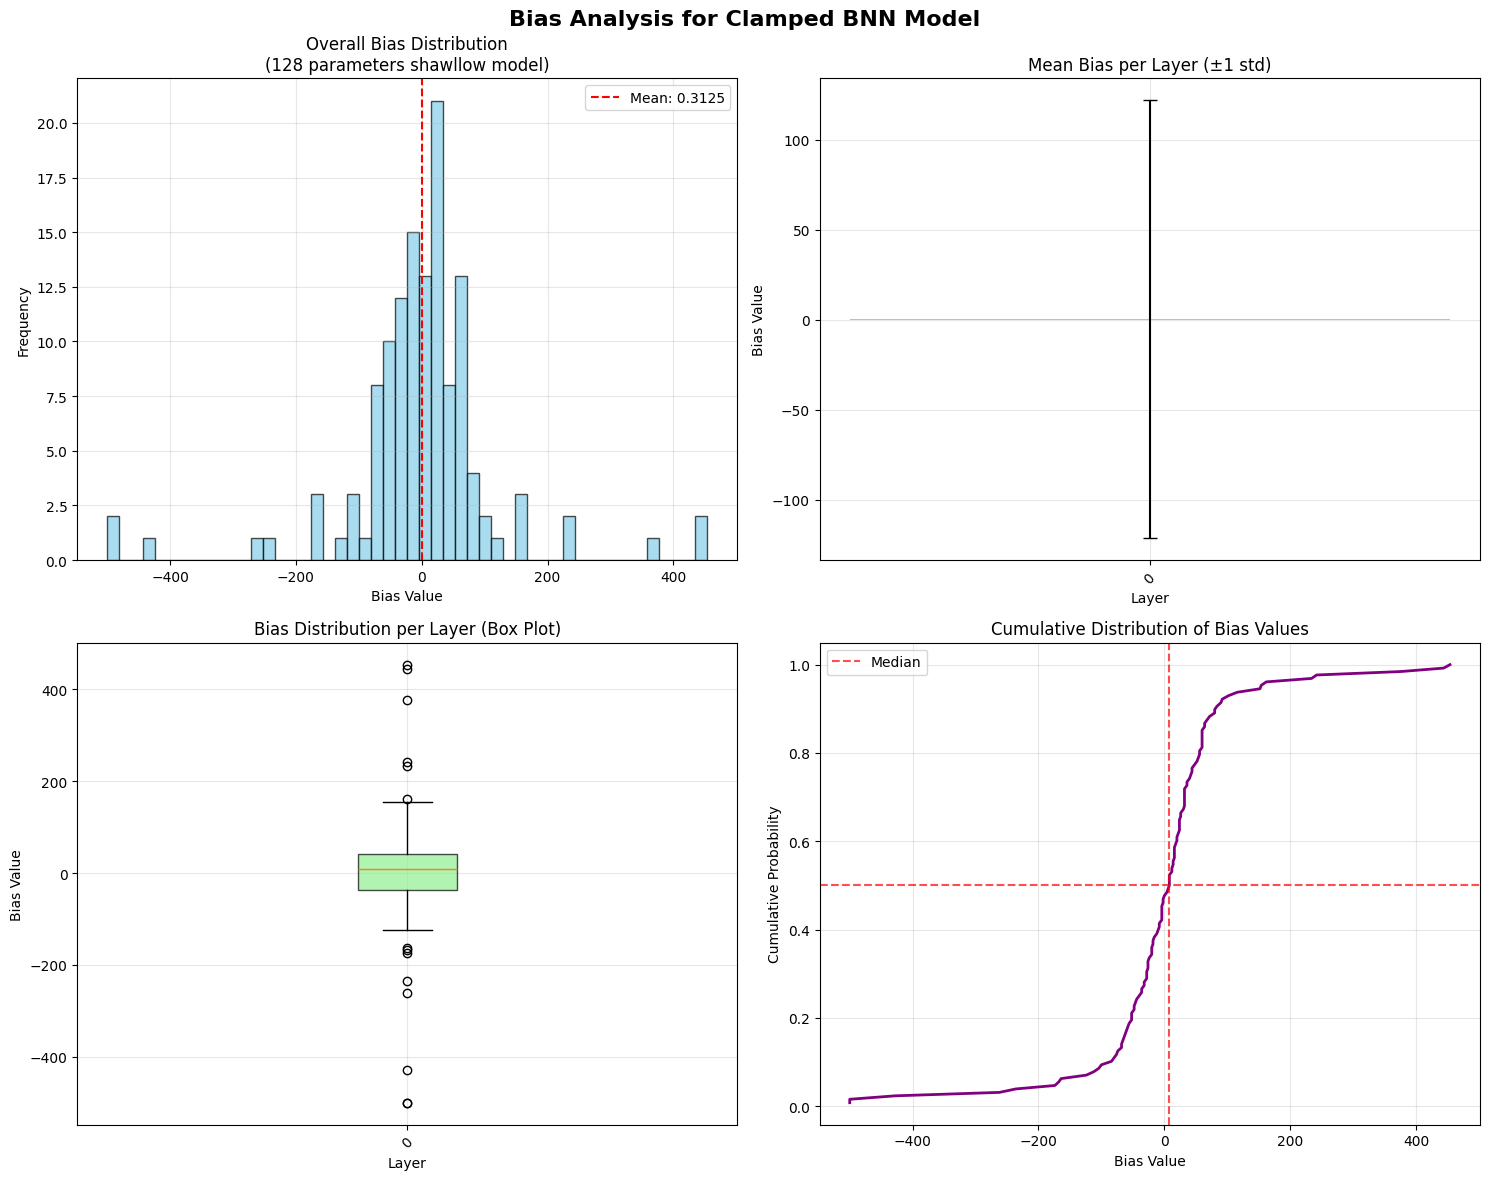

In [69]:
import matplotlib.pyplot as plt
import numpy as np

# Bias analysis and histogram visualization
all_biases = []
layer_names = []
layer_biases = {}

print("Analyzing bias values across all layers...")
for name, module in pipeline.clamped_model.named_modules():
    if hasattr(module, 'bias') and module.bias is not None:
        bias = module.bias.detach().cpu().numpy()
        all_biases.extend(bias.flatten())
        layer_names.append(name)
        layer_biases[name] = bias
        
        print(f"Layer {name}:")
        print(f"  Shape: {bias.shape}")
        print(f"  Range: [{bias.min():.4f}, {bias.max():.4f}]")
        print(f"  Mean: {bias.mean():.4f}, Std: {bias.std():.4f}")
        print(f"  Non-zero values: {np.count_nonzero(bias)}/{bias.size}")
        print()

# Convert to numpy array for easier analysis
all_biases = np.array(all_biases)
#remove outliers
# all_biases = all_biases[np.abs(all_biases) < 1000]  # Adjust threshold as needed


print(f"\nOverall bias statistics:")
print(f"Total bias parameters: {len(all_biases)}")
print(f"Range: [{all_biases.min():.4f}, {all_biases.max():.4f}]")
print(f"Mean: {all_biases.mean():.4f}, Std: {all_biases.std():.4f}")
print(f"Non-zero values: {np.count_nonzero(all_biases)}/{len(all_biases)}")

# Create comprehensive histogram visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Bias Analysis for Clamped BNN Model', fontsize=16, fontweight='bold')

# 1. Overall bias distribution
axes[0, 0].hist(all_biases, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title(f'Overall Bias Distribution\n({len(all_biases)} parameters shawllow model)')
axes[0, 0].set_xlabel('Bias Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].axvline(all_biases.mean(), color='red', linestyle='--', label=f'Mean: {all_biases.mean():.4f}')
axes[0, 0].legend()

# 2. Per-layer bias ranges
layer_means = [layer_biases[name].mean() for name in layer_names]
layer_stds = [layer_biases[name].std() for name in layer_names]
layer_ranges = [(layer_biases[name].min(), layer_biases[name].max()) for name in layer_names]

x_pos = range(len(layer_names))
axes[0, 1].bar(x_pos, layer_means, yerr=layer_stds, alpha=0.7, color='lightcoral', capsize=5)
axes[0, 1].set_title('Mean Bias per Layer (±1 std)')
axes[0, 1].set_xlabel('Layer')
axes[0, 1].set_ylabel('Bias Value')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels([name.split('.')[-1] for name in layer_names], rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# 3. Box plot for layer-wise distribution
bias_data_by_layer = [layer_biases[name].flatten() for name in layer_names]
box_plot = axes[1, 0].boxplot(bias_data_by_layer, labels=[name.split('.')[-1] for name in layer_names], patch_artist=True)
for patch in box_plot['boxes']:
    patch.set_facecolor('lightgreen')
    patch.set_alpha(0.7)
axes[1, 0].set_title('Bias Distribution per Layer (Box Plot)')
axes[1, 0].set_xlabel('Layer')
axes[1, 0].set_ylabel('Bias Value')
axes[1, 0].grid(True, alpha=0.3)
plt.setp(axes[1, 0].get_xticklabels(), rotation=45)

# 4. Cumulative distribution
sorted_biases = np.sort(all_biases)
cumulative = np.arange(1, len(sorted_biases) + 1) / len(sorted_biases)
axes[1, 1].plot(sorted_biases, cumulative, linewidth=2, color='purple')
axes[1, 1].set_title('Cumulative Distribution of Bias Values')
axes[1, 1].set_xlabel('Bias Value')
axes[1, 1].set_ylabel('Cumulative Probability')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(0.5, color='red', linestyle='--', alpha=0.7, label='Median')
axes[1, 1].axvline(np.median(all_biases), color='red', linestyle='--', alpha=0.7)
axes[1, 1].legend()

plt.tight_layout()
plt.show()
